In [1]:
%load_ext autoreload
%autoreload 2

# Allocating and Scheduling tasks to workers

In our problem setting, logistical tasks are interleaved with production activities on assembly line, and need to be aligned with timings of higher-level logistics involving deliveries of raw materials or components provided by external parties via trucks, ships, or cargo aircraft. 
These components then have to be transported to internal hangars at the right time, where they will be assembled with other aircraft parts.
We incorporate these operational requirements into the allocation and scheduling problem as part of the input data. 
More specifically, each task has a predefined release time, duration, and deadline, and certain tasks follow precedence constraints, such as when two parts must be delivered in sequence before assembly.

Given these constraints, we aim to find a feasible allocation of the worker-teams to tasks, such that 1) the total number of working teams is minimized and 2) the workload is balanced fairly among the working teams.
More specifically, we aim to minimize the __dispersion__ of working-time, which is formalized as $\max_{w \in \mathcal{W}}(\mathit{time\_worked}_w) - \min_{w \in \mathcal{W}}(\mathit{time\_worked}_w)$ with $\mathcal{W}$ a set of worker-teams.

## Pure allocation

We first model the pure-allocation version of this problem, where all tasks are fixed in time.

In [2]:
import cpmpy as cp
from models import AllocationModel
from utils import read_instance

In [3]:
instance = f"data/anon_jsons/instance_96.json"
tasks, calendars, same_allocation = read_instance(instance)

display(tasks)

,task_id,duration,team_ids,original_start,original_end,release_date,due_date,successors
0,99549,30,"{32fbb, bf019, 86287, 71de6, fb668, f59f9, 619...",0.0,30.0,0.0,60.0,{}
1,15760,15,"{32fbb, bf019, 86287, 71de6, fb668, f59f9, 619...",16.0,31.0,0.0,61.0,{}
2,37628,30,"{32fbb, bf019, 86287, 71de6, fb668, f59f9, 619...",19.0,49.0,0.0,79.0,{50284}
3,89518,15,"{32fbb, bf019, 86287, 71de6, fb668, f59f9, 619...",37.0,52.0,7.0,82.0,{81613}
4,61595,45,"{32fbb, bf019, 86287, 71de6, fb668, f59f9, 619...",14.0,59.0,0.0,89.0,{}
...,...,...,...,...,...,...,...,...
78,70248,15,"{32fbb, bf019, 86287, 71de6, fb668, f59f9, 619...",419.0,434.0,389.0,464.0,{}
79,19791,15,"{32fbb, bf019, 86287, 71de6, fb668, f59f9, 619...",424.0,439.0,394.0,469.0,{}
80,10200,30,"{32fbb, bf019, 86287, 71de6, fb668, f59f9, 619...",427.0,457.0,397.0,487.0,{}
81,39485,45,"{32fbb, bf019, 86287, 71de6, fb668, f59f9, 619...",415.0,460.0,385.0,490.0,{}


In [4]:
model = AllocationModel(tasks, calendars, same_allocation)
model.minimize(model.get_nb_teams_objective())

model.solve()

print(f"Found solution with {model.objective_value()} teams")

Found solution with 7 teams


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Solution to the allocation problem'}, xlabel='Time in minutes', ylabel='Team'>)

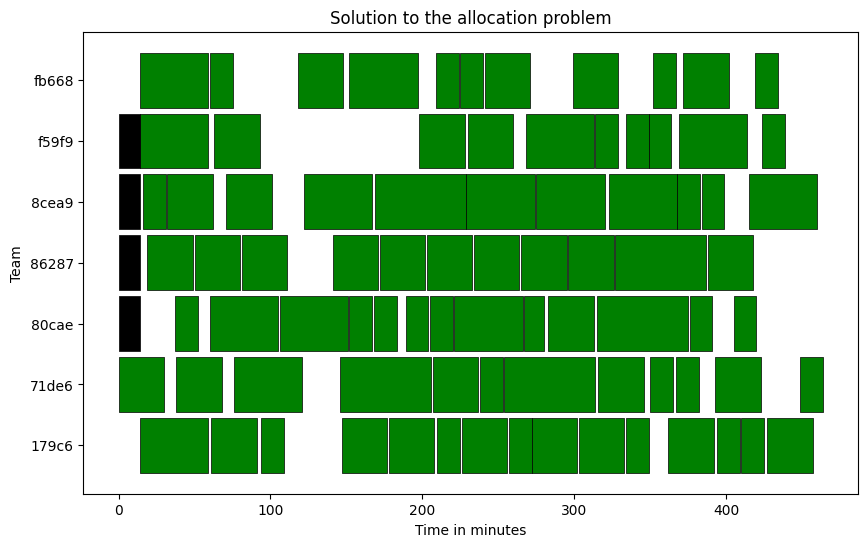

In [5]:
model.visualize_solution()

### Generating a _fair_ schedule

The above solution provides an allocation of tasks to worker-teams, while minimizing the number of teams required.
However, the schedule is not __balanced__, as some teams have to work much more compared to others.

In [6]:
sol = model.get_solution()
sol['duration'] = sol['end'] - sol['start']

working_time = sol.groupby("assigned_team")[['duration']].sum()
display(working_time)
working_time.describe()

,duration
assigned_team,
179c6,375.0
71de6,375.0
80cae,343.0
86287,360.0
8cea9,390.0
f59f9,285.0
fb668,285.0


,duration
count,7.000000
mean,344.714286
std,43.307868
min,285.000000
25%,314.000000
50%,360.000000
75%,375.000000
max,390.000000


Therefore, as a seconday objective, we also optimize the __time dispersion__ objective, which minimizes the maximum difference in time-worked between the teams.

Note that finding __optimal__ solutions to this objective is extremely hard, and solvers often get stuck in proving optimality of the solution.
Therefore, we here limit the solving-time to 5s

Objective value: 7
Objective value: 2


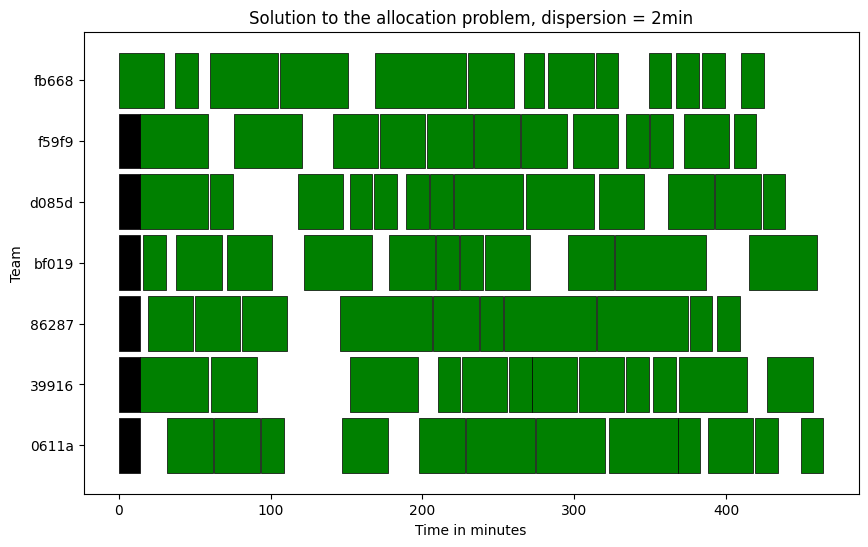

In [7]:
model.set_lexico_objectives([
    model.get_nb_teams_objective(),
    model.get_dispersion_objective()
])

model.solve(time_limit=5)
fig, ax = model.visualize_solution()
_ = ax.set_title(ax.get_title() + f", dispersion = {model.get_dispersion_value()}min")

## Scheduling and allocation

The above solution was found using the __fixed__ start and end-times for the tasks, as assigned by the human planners.

However, as you can notice, some gaps still occur in the schedule, and thus working teams will be idle.
By allowing the solver to re-schedule the tasks, we can further compactify this schedule, and potentially furhter minimize the number of teams required for working.

In [8]:
from models import SchedulingModel

In [9]:
model = SchedulingModel(tasks, calendars, same_allocation)
model.minimize(model.get_nb_teams_objective())

model.solve(time_limit=5)
print("Found solution with", model.objective_value(), "teams")
print(model.status())

Found solution with 6 teams
ExitStatus.FEASIBLE (5.013965000000001 seconds)


Clearly, this scheduling-variant of the problem is much harder compared to the pure-allocation setting, and the solver was unable to find an optimal solution in terms of number of teams required for the schedule.

However, by computing a lower-bound on the number of teams required, we can help the solver in proving optimality of the solution.
We do this by considering all teams equivalent, and minimizing the capacity in the following model:

```python
cp.Cumulative(starts, durations, ends, [1]*len(starts), capacity)
```

Here, the set of teams is modeled as a `Cumulative` resource where the capacity of the the resource corresponds to the number of working teams.

In [10]:
lb = model.get_lower_bound(add_to_model=True)
print("Found lower bound ", lb)

Found lower bound  6


In [11]:
model.set_lexico_objectives([
    model.get_nb_teams_objective(),
    model.get_dispersion_objective()
])   

model.solve(time_limit=5)
model.solver_stati

Objective value: 6
Objective value: 15


[ExitStatus.OPTIMAL (0.49336100000000005 seconds),
 ExitStatus.FEASIBLE (5.0168420000000005 seconds)]

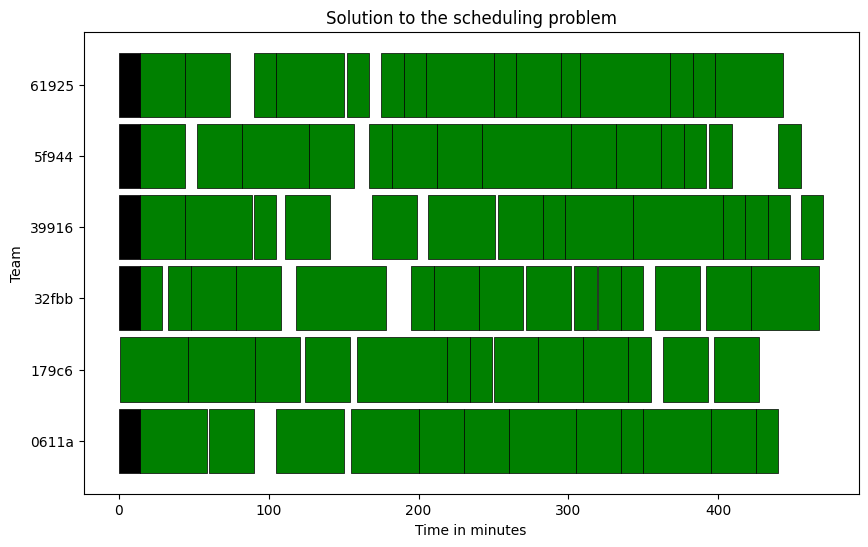

In [12]:
fig, ax = model.visualize_solution()